In [3]:
import torchtext as TT
import torch
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import spacy
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torchtext import data, datasets
from torchtext.vocab import vocab
from collections import OrderedDict

#from torchtext import vocab

with open('data/traindata.en','r') as f:
    traindata = f.readlines()
with open('data/traindata.es', 'r') as f:
    trainlabels = f.readlines()
with open('data/validdata.en','r') as f:
    validdata = f.readlines()
with open('data/validdata.es', 'r') as f:
    validlabels = f.readlines()
with open('data/testdata.en','r') as f:
    testdata = f.readlines()
with open('data/testdata.es', 'r') as f:
    testlabels = f.readlines()

spacy_es = spacy.load("es_core_news_sm")
spacy_eng = spacy.load("en_core_web_sm")


import string

def tokenize_es(text):
    return [
        tok.text.lower().strip(string.punctuation + string.whitespace)
        for tok in spacy_es(text)
        if tok.text.strip(string.punctuation + string.whitespace)
    ]

def tokenize_eng(text):
    return [
        tok.text.lower().strip(string.punctuation + string.whitespace)
        for tok in spacy_eng(text)
        if tok.text.strip(string.punctuation + string.whitespace)
    ]
'''

def tokenize_es(text):
    return [tok.text for tok in spacy_es.tokenizer(text)]

def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]
'''

train_iter = zip(traindata,trainlabels)
counter_en = Counter()
counter_es = Counter()

for (line,label) in train_iter:
    #print(label)
    counter_en.update(tokenize_eng(line))
    counter_es.update(tokenize_es(label))

#print(counter_en)  contatore frecuencia palabras
#print(counter_es)
ordered_dict_en = OrderedDict(sorted(counter_en.items(), key=lambda x: x[1], reverse=True))
ordered_dict_es = OrderedDict(sorted(counter_es.items(), key=lambda x: x[1], reverse=True))

special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']  # You can customize this list

vocab_en = vocab(ordered_dict_en, specials=special_tokens)
vocab_es = vocab(ordered_dict_es, specials=special_tokens)

#print(vocab_en.get_itos())

default_index = -1
unk_token = '<unk>'
vocab_en.set_default_index(default_index)
vocab_es.set_default_index(default_index)

vocab_en.set_default_index(vocab_en[unk_token])
vocab_es.set_default_index(vocab_es[unk_token])


    
#vocab_en = TT.vocab.Vocab(counter_en)
#vocab_es = TT.vocab.Vocab(counter_es)

## Create reverse vocabularies
#reverse_vocab_en = {index: word for word, index in vocab_en.get_stoi().items()}
#reverse_vocab_es = {index: word for word, index in vocab_es.get_stoi().items()}

#print(tokenize_es(trainlabels[0]))

text_pipeline = lambda x: [vocab_en.lookup_indices([token]) for token in tokenize_eng(x)]
label_pipeline = lambda x: [vocab_es.lookup_indices([token]) for token in tokenize_es(x)]



#print(myVocabulary.lookup_indices(['a'])) # [1, 0]
#print(myVocabulary.lookup_tokens([0]))  # ['b', 'a']

class TextData(torch.utils.data.Dataset):
    def __init__(self, text, labels):
        super(TextData, self).__init__()
        self.labels = labels
        self.text = text
        
    def __getitem__(self, index):
        return self.labels[index], self.text[index]
    
    def __len__(self):
        return len(self.labels)


def tokenize_batch(batch, max_len=10):
    '''
    tokenizer to use in DataLoader
    takes a text batch of text dataset and produces a tensor batch, converting text and labels though tokenizer, labeler
    tokenizer is a global function text_pipeline
    labeler is a global function label_pipeline
    max_len is a fixed len size, if text is less than max_len it is padded with ones (pad number)
    if text is larger that max_len it is truncated but from the end of the string
    '''
    labels_list, text_list = [], []
    for _label,_text in batch:
        #print(_text)
        #print(_label)
        labels_holder = torch.ones(max_len, dtype=torch.int64) # fixed size tensor of max_len
        processed_labels = torch.tensor(label_pipeline(_label), dtype=torch.int32).squeeze()
        pos = min(max_len, len(processed_labels))
        #print(labels_holder.shape)
        #print(processed_labels.shape)
        #print(processed_labels)
        labels_holder[-pos:] = processed_labels[-pos:]
        labels_list.append(labels_holder.unsqueeze(dim=0))
        
        text_holder = torch.ones(max_len, dtype=torch.int64) # fixed size tensor of max_len
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32).squeeze()
        pos = min(max_len, len(processed_text))
        text_holder[-pos:] = processed_text[-pos:]
        text_list.append(text_holder.unsqueeze(dim=0))
    return torch.cat(text_list, dim=0),torch.cat(labels_list, dim=0)

train_dataset = TextData(traindata,trainlabels)
valid_dataset = TextData(validdata,validlabels)
test_dataset = TextData(testdata,testlabels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=tokenize_batch)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=tokenize_batch)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=tokenize_batch)

# Create reverse vocabularies
reverse_vocab_en = {index: word for word, index in vocab_en.get_stoi().items()}
reverse_vocab_es = {index: word for word, index in vocab_es.get_stoi().items()}

def untokenize_batch(tokenized_batch,reverse_vocab, max_len=10, pad_token=0, unk_token=1):
    untokenized_batch = []
    for tokenized_sequence in tokenized_batch:
        sequence_without_padding = tokenized_sequence[tokenized_sequence != pad_token]
        sequence_without_unknown = sequence_without_padding[sequence_without_padding != unk_token]
        words = [reverse_vocab[token.item()] for token in sequence_without_unknown]

        untokenized_batch.append(words)
    return untokenized_batch

for batch in train_loader:
    txt,lbl = batch

    print("Text:", txt.shape)
    sentence = untokenize_batch(txt,reverse_vocab_en)
    print(''.join([' '.join(s) + '\n' for s in sentence]))
    
    print("Labels:", lbl.shape)
    sentence = untokenize_batch(lbl,reverse_vocab_es)
    print(''.join([' '.join(s) + '\n' for s in sentence]))
    break  # Stop after the first batch

Text: torch.Size([8, 10])
the sun is shining brightly today
i love playing with my colorful toys
let s go on a fun adventure together
flowers bloom in the spring season
my puppy likes to chase its tail
rainbows appear after the rain
the moon and stars light up the night
birds sing sweet songs in the morning

Labels: torch.Size([8, 10])
el sol brilla intensamente hoy
me encanta jugar con mis juguetes coloridos
vamos a tener una divertida aventura juntos
las flores florecen en la temporada de primavera
a mi cachorro le gusta perseguir su cola
los arcoíris aparecen después de la lluvia
la luna y las estrellas iluminan la noche
los pájaros cantan dulces canciones por la mañana



In [4]:
#######################################models
from torch import nn
import torch
import random
import numpy as np


class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, layers_size, dropout_prob,vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.layers_size = layers_size
        self.input_size = input_size
        self.dropout = nn.Dropout(dropout_prob)

        #print('embedding: ',vocab_size, embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, layers_size, bidirectional=False)  # Set bidirectional to False
        
        self.fc_hidden = nn.Linear(hidden_size, hidden_size)
        self.fc_cell = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x):
        #print('ENCODER')
        x = self.embedding(x)
        #print('Max index in x:', torch.max(x).item())
        #print('Min index in x:', torch.min(x).item())

        x = self.dropout(x)
        encoder_states, (hidden, cell) = self.lstm(x)
        hidden = self.fc_hidden(hidden)
        cell = self.fc_cell(cell)
        return encoder_states, hidden, cell

class Attention(nn.Module):
    def __init__(self, hidden_size, embedding_size, input_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

        self.Wq = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.Wk = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.Wv = nn.Parameter(torch.randn(hidden_size, embedding_size))

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.lstm = nn.LSTM(hidden_size + embedding_size, hidden_size)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, encoder_states, hidden, cell):
        #print('ATTENTION')

        x = self.dropout(x)
        sequence_length = encoder_states.shape[0]

        Q = torch.matmul(hidden, self.Wq)
        K = torch.matmul(encoder_states, self.Wk)
        V = torch.matmul(encoder_states, self.Wv)
        
        S = torch.matmul(Q, K.transpose(-2, -1))  # Transpose K along the last two dimensions
        S = S / np.sqrt(K.shape[-1])

        S = F.softmax(S, dim=-1)
        context_vector = torch.sum(S.unsqueeze(-1) * V.unsqueeze(1), dim=-2)

        attention_output = torch.cat((context_vector, x), dim=2)
        return attention_output

class DecoderWithAttention(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, layers_size, dropout_prob, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers_size = layers_size
        self.input_size = input_size
        self.dropout = nn.Dropout(dropout_prob)
        #print('embedding: ',vocab_size, embedding_size)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        #embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)


        self.attention = Attention(hidden_size, embedding_size, input_size)
        self.lstm = nn.LSTM(hidden_size + embedding_size, hidden_size, bidirectional=False)  # Set bidirectional to False
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, encoder_states, decoder_hidden, decoder_cell):
        #print('DECODER')
        #print('Max index in x:', torch.max(x).item())
        #print('Min index in x:', torch.min(x).item())
        x = self.embedding(x)
        #print('Max index in x:', torch.max(x).item())
        #print('Min index in x:', torch.min(x).item())
        decoder_input = self.attention(x, encoder_states, decoder_hidden, decoder_cell)

        output, (decoder_hidden, decoder_cell) = self.lstm(decoder_input, (decoder_hidden, decoder_cell))
        return output, decoder_hidden, decoder_cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, len_spanish_vocab, teacher_forcing_ratio=0.7):
        #print('MAIN')
        self.batch_size = source.shape[0]
        self.target_len = target.shape[1]
        self.target_vocab_size =  len_spanish_vocab
        outputs = torch.zeros(self.batch_size,self.target_len)
        encoder_states, hidden, cell = self.encoder(source)
        x = target
        
        for i in range(1, self.target_len):   #target len = 200 (sentence length), loop over words in sentence
            prediction, hidden, cell = self.decoder(x, encoder_states, hidden, cell)
            #print('MAIN2')

            log_probs = F.log_softmax(prediction, dim=2)
            predicted_indices = log_probs.argmax(dim=2) 
            outputs[:, i] = predicted_indices[:, i]
            x = target if random.random() < teacher_forcing_ratio else predicted_indices
        #print('output final',output.shape)
        return outputs
    
    def predict(self, x, max_len, len_spanish_vocab):
        encoder_states, hidden, cell = self.encoder(x)
        outputs = torch.zeros(max_len, x.shape[1], len_spanish_vocab)

        for i in range(max_len):
            prediction, hidden, cell = self.decoder(x, encoder_states, hidden, cell)
            outputs[i] = prediction
            x = prediction.argmax(1)  # Use predicted output as input for the next time step

        return outputs

Length english vocabulary: 252
Length spanish vocabulary: 254
Epoch: 1, Loss: 447332.5, Validation Loss: 27863.529296875
Epoch: 2, Loss: 416614.0, Validation Loss: 25575.2109375
Epoch: 3, Loss: 422141.21875, Validation Loss: 30206.0
Epoch: 4, Loss: 435437.59375, Validation Loss: 43545.0234375
Epoch: 5, Loss: 518707.75, Validation Loss: 20153.00390625
Epoch: 6, Loss: 525346.5625, Validation Loss: 24729.345703125
Epoch: 7, Loss: 495372.5625, Validation Loss: 31646.0
Epoch: 8, Loss: 449250.75, Validation Loss: 23767.259765625
Epoch: 9, Loss: 444635.5625, Validation Loss: 29770.025390625
Epoch: 10, Loss: 451927.6875, Validation Loss: 24610.7890625
Epoch: 11, Loss: 500081.875, Validation Loss: 25433.88671875
Epoch: 12, Loss: 463951.1875, Validation Loss: 36695.0
Epoch: 13, Loss: 577713.9375, Validation Loss: 16928.689453125
Epoch: 14, Loss: 450784.34375, Validation Loss: 30297.748046875
Epoch: 15, Loss: 478606.65625, Validation Loss: 17673.814453125
Epoch: 16, Loss: 409783.1875, Validation 

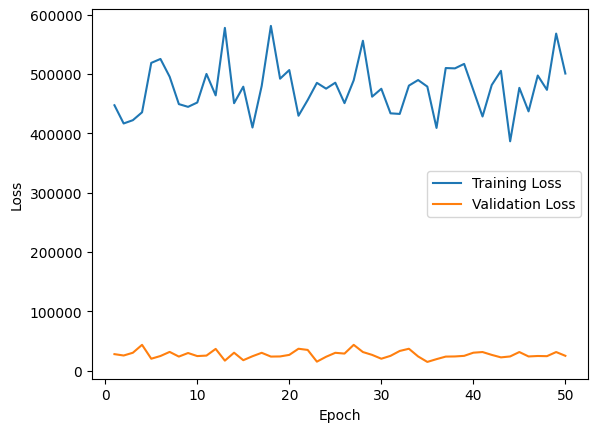

In [8]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_model = True

# Training hyperparameters
learning_rate = 0.01
batch_size = 8

# Model hyperparameters
print("Length english vocabulary:", len(vocab_en))
print("Length spanish vocabulary:",len(vocab_es))
input_size_encoder = len(vocab_en)
input_size_decoder = len(vocab_es)
output_size = len(vocab_es)
encoder_embedding_size = 128
decoder_embedding_size = 128
hidden_size = 128
num_layers = 1
enc_dropout = 0.1
dec_dropout = 0.1

step = 0

encoder_net = Encoder(input_size_encoder,
                      encoder_embedding_size, 
                      hidden_size, 
                      num_layers, 
                      enc_dropout,
                      vocab_size = len(vocab_en)
).to(device)

decoder_net = DecoderWithAttention(
                    input_size_decoder,
                    decoder_embedding_size,
                    hidden_size,
                    output_size,
                    num_layers,
                    dec_dropout,
                    vocab_size = len(vocab_es)
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


# Training loop
num_epochs = 50
train_losses = []
validation_losses = []
for epoch in range(num_epochs):
    # Training
    model.train()
    for batch in train_loader:
        english_text, spanish_text = batch
        optimizer.zero_grad()
        output = model(english_text, spanish_text,len(vocab_es))

        spanish_text=spanish_text.view(-1).float()
        spanish_text.requires_grad = True
        
        loss = criterion(output.view(-1).float(), spanish_text)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) #gradient clipping
        optimizer.step()
        #scheduler.step()

    # Validation
    model.eval()
    total_validation_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            english_text, spanish_text = batch
            optimizer.zero_grad()
            output = model(english_text, spanish_text,len(vocab_es))
            val_loss = criterion(output.view(-1).float(), spanish_text.view(-1).float())
            total_validation_loss += val_loss.item()

    average_validation_loss = total_validation_loss / len(valid_loader)
    print(f'Epoch: {epoch + 1}, Loss: {loss.item()}, Validation Loss: {average_validation_loss}')
    train_losses.append(loss.item())
    validation_losses.append(average_validation_loss)

print('ENTRENAMIENTO FINALIZADO')

# Plotting
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Create reverse vocabularies
reverse_vocab_en = {index: word for word, index in vocab_en.get_stoi().items()}
reverse_vocab_es = {index: word for word, index in vocab_es.get_stoi().items()}


# Testing (optional)
model.eval()
with torch.no_grad():
    for batch in train_loader:
        english_text, spanish_text = batch
        output = model(english_text, spanish_text,len(vocab_es))
        #log_probs = F.log_softmax(output, dim=2)
        #predicted_indices = log_probs.argmax(dim=2)
        
        print('ENGLISH INPUT TEXT: ',english_text.shape)
        sentence = untokenize_batch(english_text,reverse_vocab_en)
        print(''.join([' '.join(s) + '\n' for s in sentence]))

        print('SPANISH INPUT TEXT: ',spanish_text.shape)
        sentence = untokenize_batch(spanish_text,reverse_vocab_es)
        print(''.join([' '.join(s) + '\n' for s in sentence]))

        print('PREDICTED TEXT: ',output.shape)
        sentence = untokenize_batch(output,reverse_vocab_es)
        print(''.join([' '.join(s) + '\n' for s in sentence]))
        break

ENGLISH INPUT TEXT:  torch.Size([8, 10])
the sun is shining brightly today
i love playing with my colorful toys
let s go on a fun adventure together
flowers bloom in the spring season
my puppy likes to chase its tail
rainbows appear after the rain
the moon and stars light up the night
birds sing sweet songs in the morning

SPANISH INPUT TEXT:  torch.Size([8, 10])
el sol brilla intensamente hoy
me encanta jugar con mis juguetes coloridos
vamos a tener una divertida aventura juntos
las flores florecen en la temporada de primavera
a mi cachorro le gusta perseguir su cola
los arcoíris aparecen después de la lluvia
la luna y las estrellas iluminan la noche
los pájaros cantan dulces canciones por la mañana

PREDICTED TEXT:  torch.Size([8, 10])
ambiente cachorro centellean nuevas recién cachorro golosina centellean <sos>
ambiente divertida gusta nuevas gusta cachorro cachorro la cachorro
le cachorro durante nuevas gusta alegría otoño juegan ambiente
ambiente divertida abrazos maravillas choca

In [10]:
print(english_text)
print(spanish_text)
print(output)

tensor([[ 1,  1,  1,  1,  4, 18, 19, 49, 50, 51],
        [ 1,  1,  1, 52, 53, 54,  8, 11, 55, 56],
        [ 1,  1, 57, 58, 59, 10,  5, 60, 20, 21],
        [ 1,  1,  1,  1, 12, 22,  7,  4, 61, 62],
        [ 1,  1,  1, 11, 63, 64, 13, 65, 66, 67],
        [ 1,  1,  1,  1,  1, 68, 69, 70,  4, 71],
        [ 1,  1,  4, 72,  9, 23, 73, 24,  4, 25],
        [ 1,  1,  1, 74, 75, 76, 77,  7,  4, 14]])
tensor([[ 1,  1,  1,  1,  1,  6, 23, 24, 53, 54],
        [ 1,  1,  1, 55, 56, 57, 11, 58, 59, 60],
        [ 1,  1,  1, 61, 12, 62, 10, 63, 25, 64],
        [ 1,  1,  4, 15, 26,  8,  7, 65,  5, 27],
        [ 1,  1, 12, 28, 66, 67, 68, 69, 70, 71],
        [ 1,  1,  1,  9, 72, 73, 74,  5,  7, 75],
        [ 1,  1,  7, 76, 13,  4, 29, 77,  7, 18],
        [ 1,  1,  9, 78, 79, 80, 81, 16,  7, 30]])
tensor([[  0.,  48.,  66., 122.,  97., 119.,  66.,  84., 122.,   2.],
        [  0.,  48.,  63.,  68.,  97.,  68.,  66.,  66.,   7.,  66.],
        [  0.,  67.,  66.,  45.,  97.,  68.,  94., 113., 1